CKKS public-key encryption of message ($m$) calculates : 

$(c_0,c_1)=((p_0v+e_0+m),(p_1v+e1))(modQ),$

, where $p_0$, $p_1$ are the public key components, $v$ is a random ring element in $R_Q$ following a uniform distribution, and $e_0$, $e_1$ are random ring elements from a truncated Gaussian distribution.

To fix the encryption, you’ll need to manually modify the random elements mentioned above. Be aware that this is an invasive procedure and carries risks. OpenFHE doesn’t provide any built-in methods for this modification.

CKKS encryption logic can be found [here](https://github.com/openfheorg/openfhe-development/blob/v1.1.2/src/pke/lib/schemerns/rns-pke.cpp#L55).

https://openfhe.discourse.group/t/ckks-controling-prng-in-encryption/999/3

In [1]:
import math
import numpy as np
from dataclasses import dataclass

In [2]:
# ------------------------------
# Discrete Gaussian via CDT
# ------------------------------
@dataclass
class GaussianCDTTable:
    sigma: float
    tail_sigma: float = 10.0  # truncate at ~10*sigma by default

    def __post_init__(self):
        # Build nonnegative-side probabilities P[X = k] ∝ exp(-pi * k^2 / sigma^2)
        # for k >= 0 (we will add sign later; note that k=0 is unique).
        tmax = max(20, int(math.ceil(self.tail_sigma * self.sigma)))
        ks = np.arange(0, tmax + 1, dtype=np.int64)
        rho = np.exp(-math.pi * (ks.astype(np.float64) ** 2) / (self.sigma ** 2))
        # Normalize for nonnegative side (we sample k >= 0; sign handled after)
        Z = rho.sum()
        p = rho / Z  # P_nonneg[k]
        cdf = np.cumsum(p)
        cdf[-1] = 1.0  # guard against float drift
        self.ks = ks
        self.cdf = cdf

    def sample_nonneg(self, n: int, rng: np.random.Generator) -> np.ndarray:
        u = rng.random(n)
        idx = np.searchsorted(self.cdf, u, side="left")
        return self.ks[idx]

def sample_discrete_gaussian_cdt(n: int, sigma: float, tail_sigma: float = 10.0,
                                 rng: np.random.Generator | None = None) -> np.ndarray:
    """
    Two-sided discrete Gaussian via CDT on the nonnegative side + random sign.
    Returns integer samples with stddev approximately sigma (tail truncated).
    """
    if rng is None:
        rng = np.random.default_rng()
    table = GaussianCDTTable(sigma=sigma, tail_sigma=tail_sigma)
    k = table.sample_nonneg(n, rng)
    # random sign for k>0 (k=0 stays 0)
    s = rng.integers(0, 2, size=n, dtype=np.int8) * 2 - 1  # in {-1, +1}
    x = (k * s).astype(np.int64)
    x[k == 0] = 0
    return x

Target sigma: 3.2
Empirical mean: -0.0033
Empirical std:  1.1152


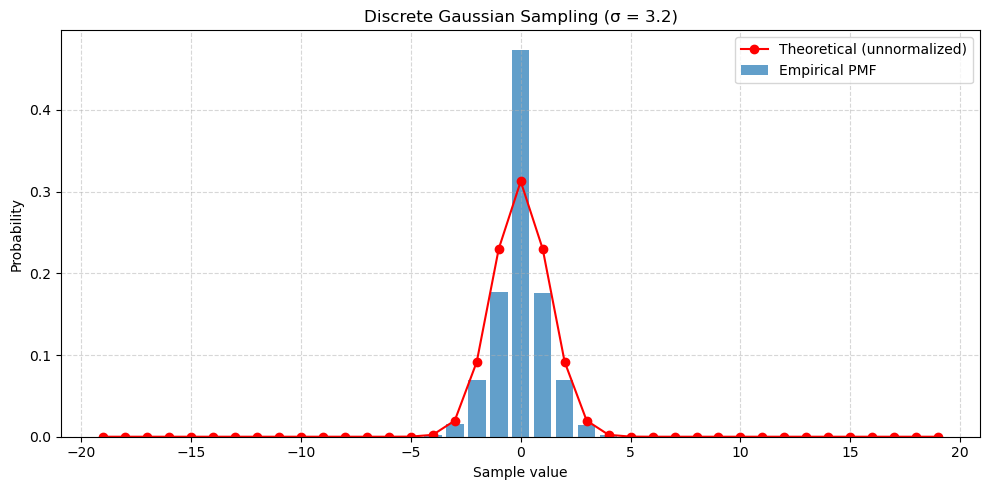


First 20 samples: [ 1  0  2  1  0  3 -1  1  0  0  0  2  1 -1  0  0  1  0 -2  1]


In [3]:
import math
import numpy as np
from dataclasses import dataclass
import matplotlib.pyplot as plt

# ------------------------------
# Discrete Gaussian via CDT
# ------------------------------
@dataclass
class GaussianCDTTable:
    sigma: float
    tail_sigma: float = 10.0  # truncate at ~10*sigma by default

    def __post_init__(self):
        # Build nonnegative-side probabilities P[X = k] ∝ exp(-pi * k^2 / sigma^2)
        tmax = max(20, int(math.ceil(self.tail_sigma * self.sigma)))
        ks = np.arange(0, tmax + 1, dtype=np.int64)
        rho = np.exp(-math.pi * (ks.astype(np.float64) ** 2) / (self.sigma ** 2))
        Z = rho.sum()
        p = rho / Z
        cdf = np.cumsum(p)
        cdf[-1] = 1.0  # guard against float drift
        self.ks = ks
        self.cdf = cdf

    def sample_nonneg(self, n: int, rng: np.random.Generator) -> np.ndarray:
        u = rng.random(n)
        idx = np.searchsorted(self.cdf, u, side="left")
        return self.ks[idx]


def sample_discrete_gaussian_cdt(
    n: int,
    sigma: float,
    tail_sigma: float = 10.0,
    rng: np.random.Generator | None = None
) -> np.ndarray:
    """
    Two-sided discrete Gaussian via CDT on the nonnegative side + random sign.
    Returns integer samples with stddev approximately sigma (tail truncated).
    """
    if rng is None:
        rng = np.random.default_rng()
    table = GaussianCDTTable(sigma=sigma, tail_sigma=tail_sigma)
    k = table.sample_nonneg(n, rng)
    # random sign for k > 0; k=0 stays 0
    signs = rng.integers(0, 2, size=n, dtype=np.int8) * 2 - 1  # {-1, +1}
    x = k * signs
    x[k == 0] = 0  # ensure zero stays zero (redundant but safe)
    return x.astype(np.int64)


# ------------------------------
# Example Usage
# ------------------------------
if __name__ == "__main__":
    # Parameters
    sigma = 3.2          # Standard deviation (common in RLWE: e.g., 3.2)
    n_samples = 100_000  # Number of samples to generate
    seed = 42            # For reproducibility

    # Create RNG
    rng = np.random.default_rng(seed)

    # Generate samples
    samples = sample_discrete_gaussian_cdt(n=n_samples, sigma=sigma, rng=rng)

    # Basic statistics
    empirical_std = np.std(samples)
    empirical_mean = np.mean(samples)
    print(f"Target sigma: {sigma}")
    print(f"Empirical mean: {empirical_mean:.4f}")
    print(f"Empirical std:  {empirical_std:.4f}")

    # Plot histogram
    plt.figure(figsize=(10, 5))
    values, counts = np.unique(samples, return_counts=True)
    plt.bar(values, counts / n_samples, width=0.8, alpha=0.7, label="Empirical PMF")
    
    # Overlay theoretical probabilities (for comparison)
    k_vals = np.arange(-int(6*sigma), int(6*sigma)+1)
    theoretical_p = np.exp(-np.pi * (k_vals ** 2) / (sigma ** 2))
    theoretical_p /= theoretical_p.sum()  # normalize
    plt.plot(k_vals, theoretical_p, 'ro-', label="Theoretical (unnormalized)")

    plt.title(f"Discrete Gaussian Sampling (σ = {sigma})")
    plt.xlabel("Sample value")
    plt.ylabel("Probability")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Example: small batch of actual samples
    print("\nFirst 20 samples:", samples[:20])

In [5]:
import numpy as np
from math import ceil
# ---------- build integer CDT (nonnegative) ----------
def build_cdt_int(sigma, tail_sigma=10.0, lam=64):
    tmax = max(20, int(ceil(tail_sigma*sigma)))
    k = np.arange(0, tmax+1, dtype=np.int64)
    rho = np.exp(-np.pi * (k**2) / (sigma**2))
    p = rho / rho.sum()                  # normalize NONNEG side
    cdf = np.minimum(np.cumsum(p), 1.0)
    T = np.minimum((cdf * (1<<lam)).astype(np.uint64), (1<<lam)-1)  # integer thresholds
    return k, T

# ---------- fixed-iteration CDT binary search ----------
def cdt_sample_idx(T, r):
    # search smallest idx with r < T[idx]
    N = len(T)
    jmp = 1 << (N.bit_length()-1)   # >= N/2
    cur = 0
    while jmp > 0:
        nxt = cur + jmp
        if nxt < N and r >= T[nxt]:
            cur = nxt
        jmp >>= 1
    return cur  # nonnegative index

# ---------- generate samples (±k) ----------
def sample_gauss(n, T, lam=64, rng=None):
    rng = rng or np.random.default_rng(123)
    r = rng.integers(0, 1<<lam, size=n, dtype=np.uint64)
    idx = np.array([cdt_sample_idx(T, ri) for ri in r], dtype=np.int64)
    b = rng.integers(0, 2, size=n, dtype=np.int8)  # sign bit
    x = (1 - 2*b) * idx
    x[idx==0] = 0
    return x, r, b, idx

# ---------- stats + quick tests ----------
if __name__ == "__main__":
    sigma = 3.2
    k, T = build_cdt_int(sigma, tail_sigma=10.0, lam=64)
    x, r, b, idx = sample_gauss(200_000, T, lam=64)

    print(f"mean≈0? {x.mean():.4f},  std≈σ? {x.std():.4f} (target σ={sigma})")
    # 3σ rule sanity:
    frac_out_3sigma = (np.abs(x) > 3*sigma).mean()
    print(f"P(|x|>3σ) ≈ {frac_out_3sigma:.4f}  (expected ~0.003–0.01 depending on discretization)")

    # ---- write goldens for RTL testbench ----
    # CDF table
    np.savetxt("cdt_table.hex", T, fmt="%016x")  # 64-bit hex per line
    # stimuli r & b, expected index and signed x
    np.savetxt("stim_r.hex", r, fmt="%016x")
    np.savetxt("stim_b.hex", b, fmt="%01x")
    np.savetxt("gold_idx.hex", idx, fmt="%08x")
    # If your RTL outputs mod-q values instead of ±k:
    #   x_mod = np.where(b==0, idx, (q - idx) % q).astype(np.uint64)
    # else (±k integer):
    x_signed = (x.astype(np.int64) & ((1<<64)-1))  # two's complement for 64b compare
    np.savetxt("gold_x.hex", x_signed, fmt="%016x")


mean≈0? 0.0027,  std≈σ? 0.5449 (target σ=3.2)
P(|x|>3σ) ≈ 0.0000  (expected ~0.003–0.01 depending on discretization)


OverflowError: Python int too large to convert to C long